# TalkingData-Fraud-Detection

In [1]:
%matplotlib inline

df = pd.read_csv("./train.csv", nrows=2000)
df.tail(2)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
1998,73839,12,1,17,265,2017-11-06 16:00:02,NaN,0
1999,105475,14,1,44,480,2017-11-06 16:00:02,NaN,0


dataset 은 이런식으로 생겼습니다.

- kaggle에서 데이터셋을 받고 압축을 풀어보시면, 7G가 넘는 방대한 데이터셋을 보실 수 있습니다.
- 십만개의 데이터로 구성된 train_sample만 이용하셔도 괜찮습니다.

    https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/data

# EDA
탐색적 데이터 분석, 즉 분석 기법 등을 쓰지 않고 데이터 자체를 확인하는 과정입니다.

- 일반적으로 
데이터 전처리는 데이터 셋 확인, 결측값 처리, 이상값 처리, Feature Engineering 으로 진행됩니다.
- Fraud-Detection 데이터는 결측값이 없고, 데이터도 click_time 하나를 제외하고는 모두 숫자로 구성되어 있기 때문에 전처리 할 것이 거의 없습니다.
- attributed_time은 is_attributed가 1인 데이터들만 존재하기 때문에 인사이트를 얻을 수는 있지만, 학습에는 사용하지 않습니다.

아래 변수 설명은 Kaggle에서 발췌해왔습니다.

### 독립 변수 (inddependent variables)

#### user discriminator 
제가 생각하기에, 고유 유저를 구분짓는 변수가 아닐까 합니다.
>- `ip`: ip address of click. 
    
>- `device`: device type id of user mobile phone 
    - (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)

>- `os`: os version id of user mobile phone

#### ad discriminator
ad의 출처 등을 구분짓는 변수라고 생각합니다.
>- `app`: app id for marketing.
>- `channel`: channel id of mobile ad publisher

#### others
>- `click_time`: timestamp of click (UTC)
>- `attributed_time`: if user download the app for after clicking an ad, this is the time of the app download 

### 종속 변수 (dependent variable)

- `is_attributed`: the target that is to be predicted, indicating the app was downloaded

---

`Note that ip, app, device, os, and channel are encoded.`
- 변수들이 인코딩되었다고 합니다. 보안문제도 있었을테지만, 아무튼 인코딩하는 과정이 줄어 땡큐네요. 
- 일반적으로는 직접 인코딩을 거치는 경우가 많습니다. 

### 평가 방식 (Evaluation)

**AUC** : Area Under the ROC curve (ROC - Receiver Operating Characteristic curve)

ROC커브란 `1` 클래스 판별 기준값 변화에 따른(threshold) `2` recall과 `3` fall-out의 변화를 시각화한 것이고,

AUC는 ROC커브 아랫 부분의 면적을 의미합니다.

*이게 무슨 소리냐 하시면..*

일단 분류 결과표부터.

|실제\예측 | Positive 라고 예측 | Negative 라고 예측|
| -- | -- | -- |
|실제 Positive| True Positive | False Negative
|실제 Negative| False Positive | True Negative

1. 클래스 판별 기준값 
>모든 이진 분류 모형은 판별 평면으로부터의 거리에 해당하는 판별 함수(discriminant function)를 가지며 판별 함수 값이 음수이면 0인 클래스, 양수이면 1인 클래스에 해당한다고 판별한다. 즉 0 이 클래스 판별 기준값이 된다. ROC 커브는 이 클래스 판별 기준값이 달라진다면 판별 결과가 어떻게 달라지는지는 표현한 것이다.  https://datascienceschool.net/view-notebook/731e0d2ef52c41c686ba53dcaf346f32/

2. recall : 실제 앱을  **구매한** click 중 **구매했다고** 출력한 click의 수

$$ \text{recall} = \dfrac{TP}{TP + FN} $$

3. fall-out : 실제 앱 구매하지 **않은** click 중 클래스에 **구매했다고** 출력한 click의 수

$$ \text{fall-out} = \dfrac{FP}{FP + TN} $$



일반적으로 클래스 판별 기준(Threshold)이 변화함에 따라 Recall과 Fall-out은 같이 증가하거나 감소합니다. 

따라서 Fall-out보다 Recall이 더 빠르게 증가하는 모형일수록 AUC가 1에 가까운 모형이며, (민감한) 좋은 모형이라고 합니다.

---

In [2]:
df = pd.read_csv("./data/edited.csv", skiprows=lambda i: i % 1000 != 0)
df.tail()

,ip,app,device,os,channel,is_attributed,hour,unique_app,unique_device,unique_os,unique_channel,unique_hour,IDO_app,IDO_ch,AC_ch,CA_app
184898,86767,94,1,13,361,0,15,34,3,43,108,1,31,84,2,1
184899,364401,94,1,13,361,0,15,13,1,1,20,1,13,20,2,1
184900,77257,29,1,3,343,0,15,20,3,14,48,1,1,1,14,3
184901,99020,29,1,1,343,0,15,6,1,3,6,1,1,1,14,3
184902,64049,160,1,19,457,0,15,20,1,5,33,1,18,25,1,1


In [3]:
df.describe()

,ip,app,device,os,channel,is_attributed,hour,unique_app,unique_device,unique_os,unique_channel,unique_hour,IDO_app,IDO_ch,AC_ch,CA_app
count,184903.000000,184903.000000,184903.000000,184903.000000,184903.000000,184903.000000,184903.000000,184903.000000,184903.000000,184903.000000,184903.000000,184903.000000,184903.00000,184903.000000,184903.000000,184903.000000
mean,91013.889672,12.132053,21.783286,22.652591,268.585123,0.002493,9.300006,19.291044,2.375240,16.585718,41.766418,1.653791,9.36934,16.421626,21.783741,3.895118
std,69723.809109,16.254858,259.553787,55.606948,129.584146,0.049870,6.171851,10.414113,2.947847,16.965074,24.416244,0.711170,6.30194,16.680015,11.345737,8.123366
min,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
25%,40245.000000,3.000000,1.000000,13.000000,140.000000,0.000000,4.000000,13.000000,1.000000,6.000000,23.000000,1.000000,4.00000,4.000000,11.000000,2.000000
50%,79827.000000,12.000000,1.000000,18.000000,258.000000,0.000000,9.000000,18.000000,1.000000,10.000000,39.000000,2.000000,9.00000,12.000000,26.000000,3.000000
75%,118229.000000,15.000000,1.000000,19.000000,379.000000,0.000000,14.000000,23.000000,3.000000,20.000000,56.000000,2.000000,13.00000,22.000000,30.000000,4.000000
max,364776.000000,755.000000,3867.000000,866.000000,498.000000,1.000000,23.000000,88.000000,42.000000,95.000000,132.000000,5.000000,37.00000,115.000000,39.000000,133.000000


In [4]:
df.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'hour',
       'unique_app', 'unique_device', 'unique_os', 'unique_channel',
       'unique_hour', 'IDO_app', 'IDO_ch', 'AC_ch', 'CA_app'],
      dtype='object')

## Categorical Features

click_time에서 hour만 추출해 변수로 사용했습니다. 나머지는 주어진대로.

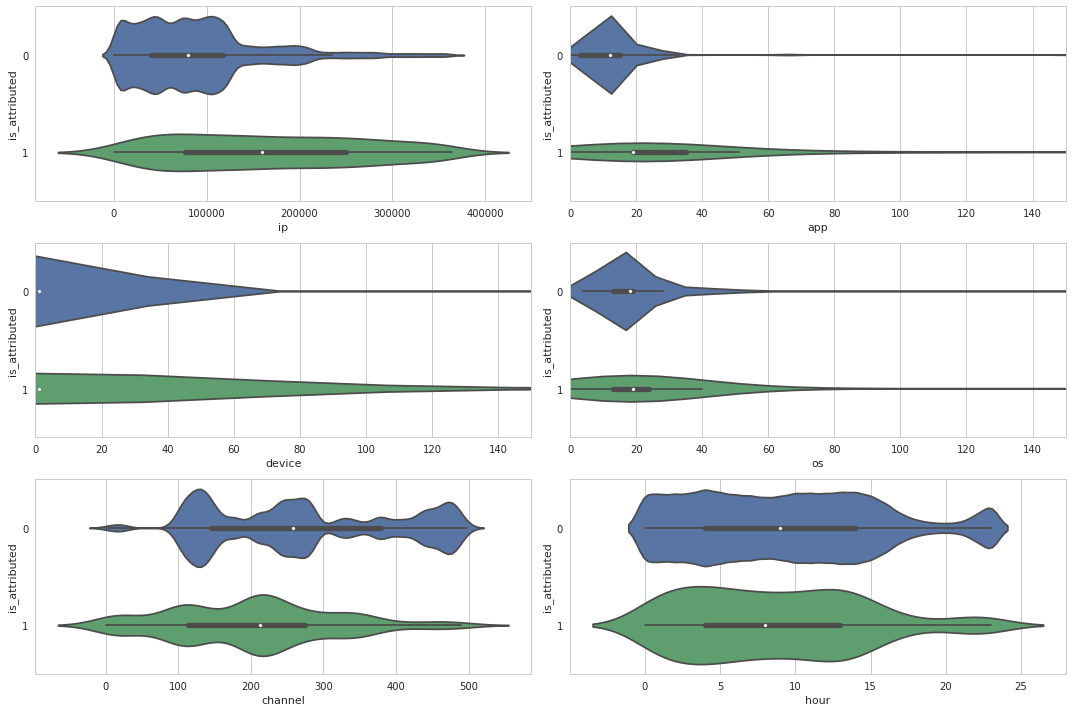

In [5]:
plt.figure(figsize=(15,10))
plt.subplot(321)
sns.violinplot(x = 'ip', y = 'is_attributed', data=df, orient='h')
plt.subplot(322)
sns.violinplot(x = 'app', y = 'is_attributed', data=df, orient='h')
plt.xlim(0, 150)
plt.subplot(323)
sns.violinplot(x = 'device', y = 'is_attributed', data=df, orient='h')
plt.xlim(0, 150)
plt.subplot(324)
sns.violinplot(x = 'os', y = 'is_attributed', data=df, orient='h')
plt.xlim(0, 150)
plt.subplot(325)
sns.violinplot(x = 'channel', y = 'is_attributed', data=df, orient='h')
plt.subplot(326)
sns.violinplot(x = 'hour', y = 'is_attributed', data=df, orient='h')
plt.tight_layout()
plt.show()

클래스에 따라 분포의 모양이 다른 걸 보니, 앱을 구매한 여부에 대한 설명력이 있는 변수들인듯 싶습니다.
- app, device, os의 경우에는 비대칭 데이터이기 때문에 다른 분포처럼 보이는 걸 수도 있습니다.

### feature engineering 
주어진 자료들로 만들어냈던 변수들입니다. 
- `0.edit_data.py` 에 코드가 있습니다.

>unique_&&:  동일 ip 그룹별로 이용된 (app, device, os, channel, hour) 갯수 

>IDO_app : 동일 ip-device-os 그룹별로 이용된 app 갯수

>IDO_ch : 동일 ip-device-os 그룹별로 이용된 channel 갯수

>AC_ch : app별 광고 channel 갯수

>CA_app : channel별 담당 app 갯수

## Numerical Features
Boxplot과 vilolinplot으로 그려봤습니다.

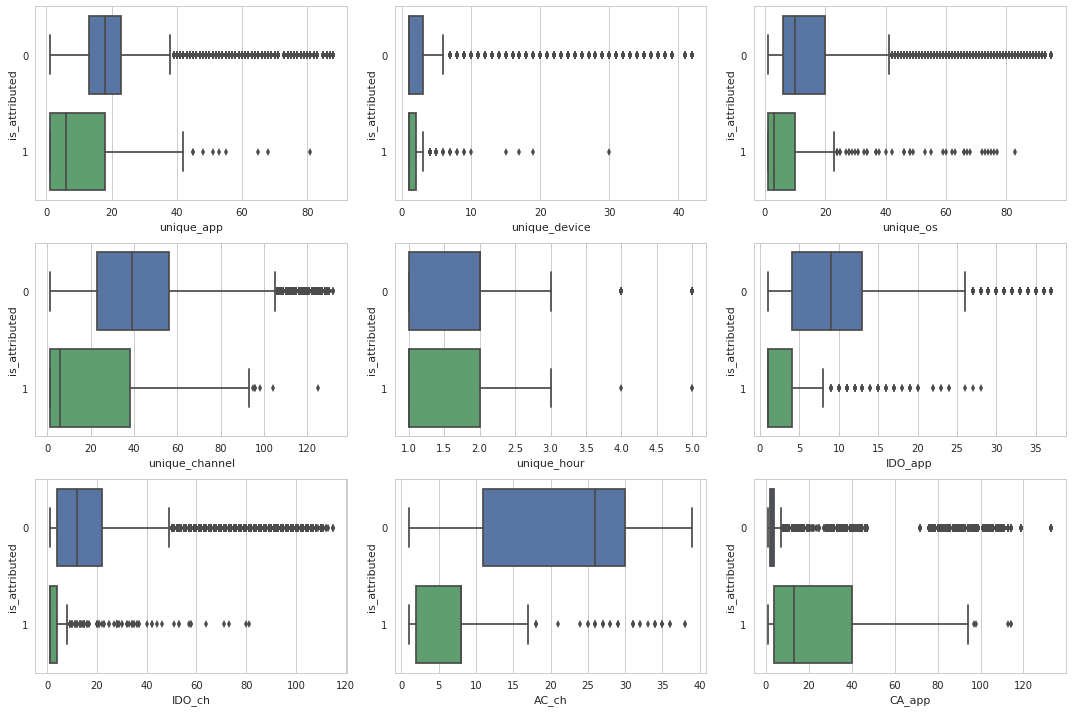

In [6]:
plt.figure(figsize=(15,10))
plt.subplot(331)
sns.boxplot(x = 'unique_app', y = 'is_attributed', data=df, orient='h')
plt.subplot(332)
sns.boxplot(x = 'unique_device', y = 'is_attributed', data=df, orient='h')
plt.subplot(333)
sns.boxplot(x = 'unique_os', y = 'is_attributed', data=df, orient='h')
plt.subplot(334)
sns.boxplot(x = 'unique_channel', y = 'is_attributed', data=df, orient='h')
plt.subplot(335)
sns.boxplot(x = 'unique_hour', y = 'is_attributed', data=df, orient='h')
plt.subplot(336)
sns.boxplot(x = 'IDO_app', y = 'is_attributed', data=df, orient='h')
plt.subplot(337)
sns.boxplot(x = 'IDO_ch', y = 'is_attributed', data=df, orient='h')
plt.subplot(338)
sns.boxplot(x = 'AC_ch', y = 'is_attributed', data=df, orient='h')
plt.subplot(339)
sns.boxplot(x = 'CA_app', y = 'is_attributed', data=df, orient='h')
plt.tight_layout()
plt.show()

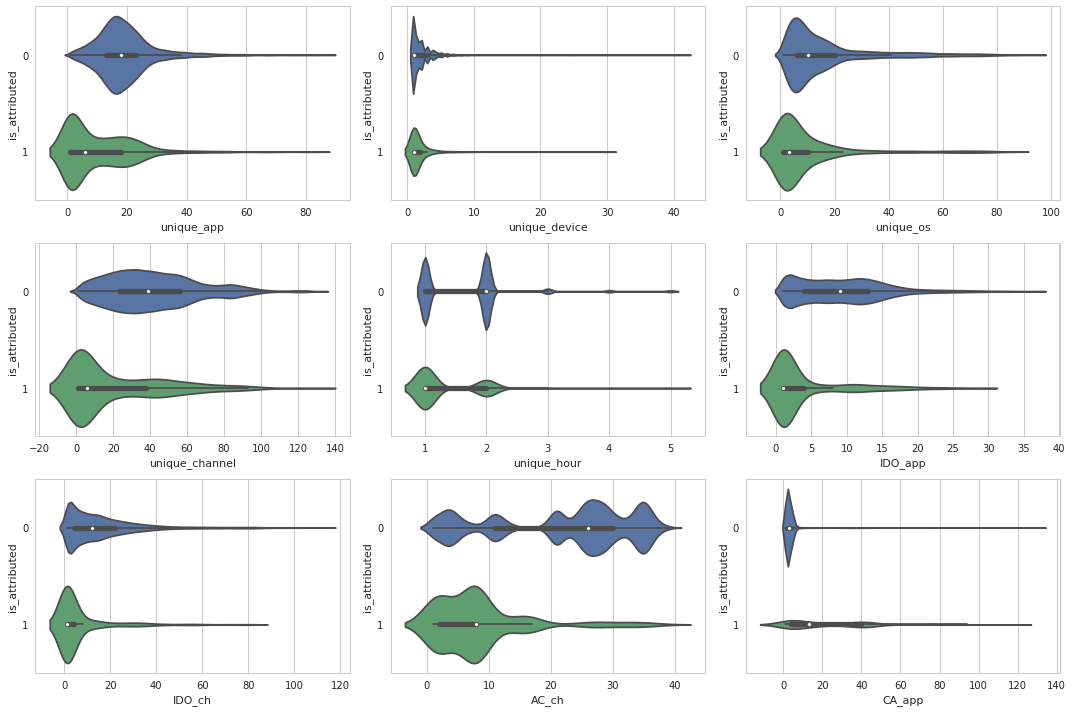

In [7]:
plt.figure(figsize=(15,10))
plt.subplot(331)
sns.violinplot(x = 'unique_app', y = 'is_attributed', data=df, orient='h', split=True)
plt.subplot(332)
sns.violinplot(x = 'unique_device', y = 'is_attributed', data=df, orient='h')
plt.subplot(333)
sns.violinplot(x = 'unique_os', y = 'is_attributed', data=df, orient='h')
plt.subplot(334)
sns.violinplot(x = 'unique_channel', y = 'is_attributed', data=df, orient='h')
plt.subplot(335)
sns.violinplot(x = 'unique_hour', y = 'is_attributed', data=df, orient='h')
plt.subplot(336)
sns.violinplot(x = 'IDO_app', y = 'is_attributed', data=df, orient='h')
plt.subplot(337)
sns.violinplot(x = 'IDO_ch', y = 'is_attributed', data=df, orient='h')
plt.subplot(338)
sns.violinplot(x = 'AC_ch', y = 'is_attributed', data=df, orient='h')
plt.subplot(339)
sns.violinplot(x = 'CA_app', y = 'is_attributed', data=df, orient='h')
plt.tight_layout()
plt.show()

### 비대칭 문제가 해결된다면?

undersampling으로 과도하게 많은 클래스를 줄였습니다.
- 과정은 모델링과 함께 서술했습니다.

In [8]:
df = pd.read_csv("./data/undersampled.csv")

print("app구매 고객 / 전체 고객: ", df.is_attributed.sum()/len(df) )
print("샘플링 후 전체 데이터 수 : ", len(df))

app구매 고객 / 전체 고객:  0.5
샘플링 후 전체 데이터 수 :  913692


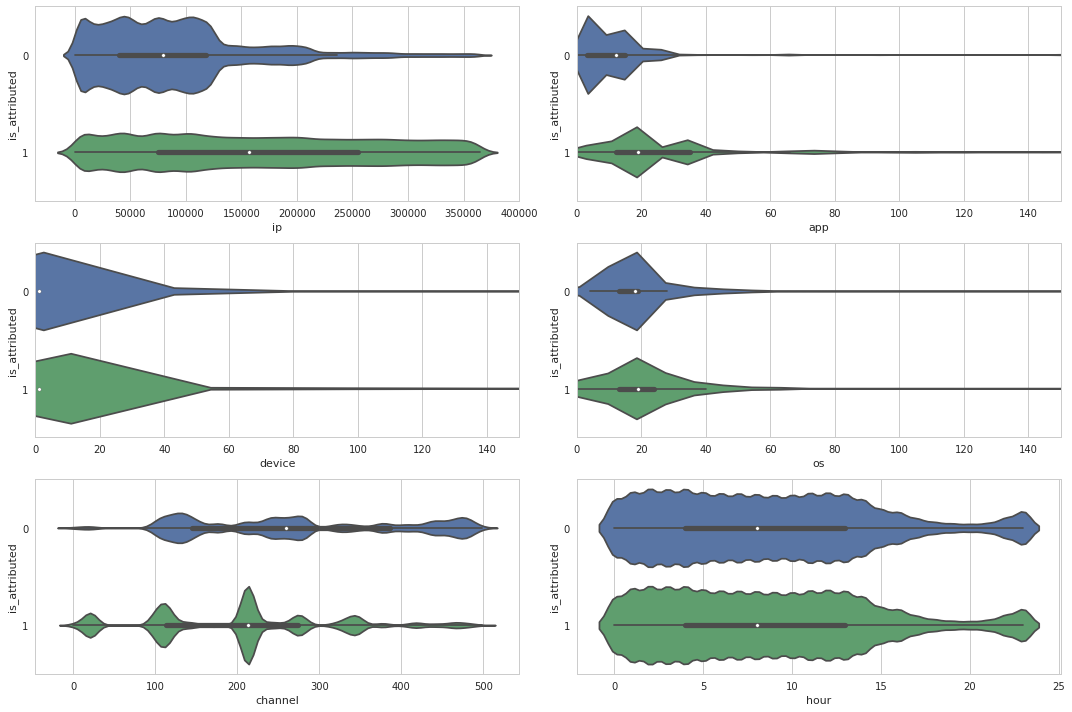

In [9]:
plt.figure(figsize=(15,10))
plt.subplot(321)
sns.violinplot(x = 'ip', y = 'is_attributed', data=df, orient='h')
plt.subplot(322)
sns.violinplot(x = 'app', y = 'is_attributed', data=df, orient='h')
plt.xlim(0, 150)
plt.subplot(323)
sns.violinplot(x = 'device', y = 'is_attributed', data=df, orient='h')
plt.xlim(0, 150)
plt.subplot(324)
sns.violinplot(x = 'os', y = 'is_attributed', data=df, orient='h')
plt.xlim(0, 150)
plt.subplot(325)
sns.violinplot(x = 'channel', y = 'is_attributed', data=df, orient='h')
plt.subplot(326)
sns.violinplot(x = 'hour', y = 'is_attributed', data=df, orient='h')
plt.tight_layout()
plt.show()

비대칭 문제를 (어느정도) 해결하고 보니 hour의 경우 클래스간의 구분이 거의 되지 않는 것을 알 수 있다.
- 변수 제외를 한다면 hour를 일순위로 선택해야하지 않을까?

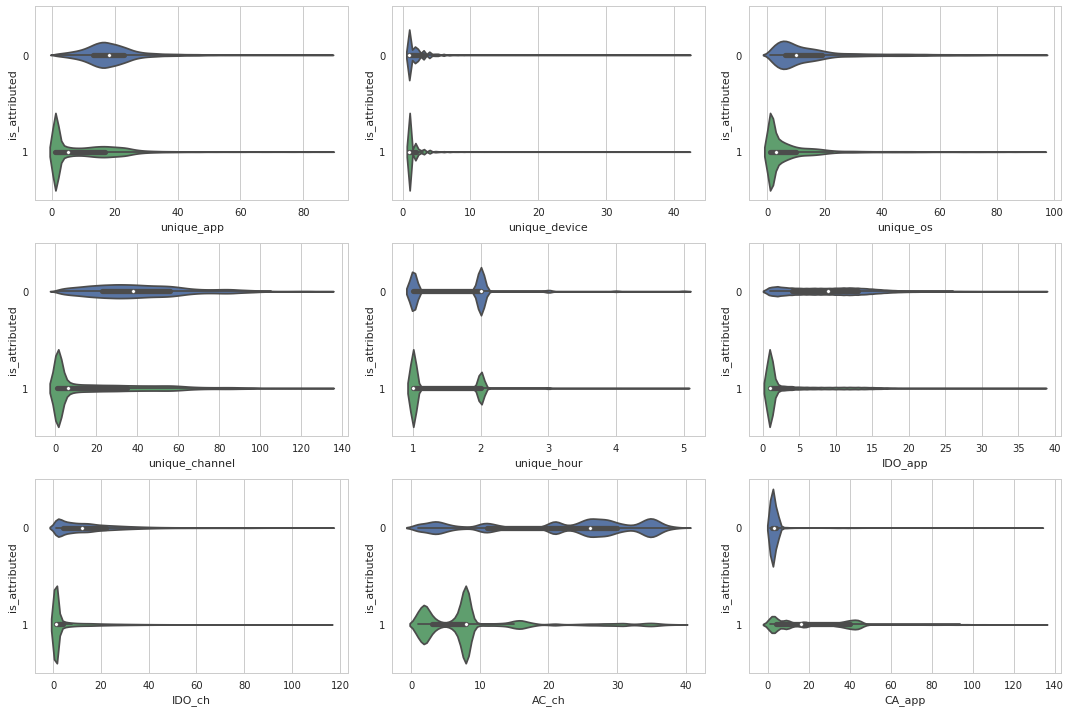

In [10]:
plt.figure(figsize=(15,10))
plt.subplot(331)
sns.violinplot(x = 'unique_app', y = 'is_attributed', data=df, orient='h', split=True)
plt.subplot(332)
sns.violinplot(x = 'unique_device', y = 'is_attributed', data=df, orient='h')
plt.subplot(333)
sns.violinplot(x = 'unique_os', y = 'is_attributed', data=df, orient='h')
plt.subplot(334)
sns.violinplot(x = 'unique_channel', y = 'is_attributed', data=df, orient='h')
plt.subplot(335)
sns.violinplot(x = 'unique_hour', y = 'is_attributed', data=df, orient='h')
plt.subplot(336)
sns.violinplot(x = 'IDO_app', y = 'is_attributed', data=df, orient='h')
plt.subplot(337)
sns.violinplot(x = 'IDO_ch', y = 'is_attributed', data=df, orient='h')
plt.subplot(338)
sns.violinplot(x = 'AC_ch', y = 'is_attributed', data=df, orient='h')
plt.subplot(339)
sns.violinplot(x = 'CA_app', y = 'is_attributed', data=df, orient='h')
plt.tight_layout()
plt.show()